# Import Modules

First, run `pip install methylsuite` from your computer's command line terminal. 

In [1]:
import methylprep
import methylcheck
import methylize
import pandas as pd
from pathlib import Path
filepath = Path('/Users/patriciagirardi/tutorial/GPL21145')


# Download Example Data

You may use the command line interface (CLI) of `methylprep` to download one of the >100,000 datasets stored on NIH's GEO repository.

We will use the CLI to download a an example dataset from GEO (GSE147391) for this walkthrough. Run the following command from your computer's terminal to do so. 

```shell
>>> python -m methylprep -v download -i GSE147391 -d <filepath> -o
```

where `<filepath>` is the directory you would like to store the files in. The `-o` option is used to download the data without processing it. 

Alternatively, visit [this page](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147391) and download the raw IDAT files from GSE147391 for this tutorial. 

# Processing raw IDAT files using `methylprep`

## Introduction

`methylprep` has been tested and benchmarked to match the outputs of two popular methylation data processing R packages: [sesame](https://bioconductor.org/packages/release/bioc/html/sesame.html) (v1.10.4) and [minfi](https://bioconductor.org/packages/release/bioc/html/minfi.html) (v1.38). Our documentation is online/interactive and is updated regularly as features are added to the package.

The processing pipeline is as follows:
- infer type-I channel switch
- NOOB (normal-exponential convolution on out-of-band probe data)
- poobah (p-value with out-of-band array hybridization, for filtering lose signal-to-noise probes)
- qualityMask (to exclude historically less reliable probes)
- nonlinear dye bias correction (AKA signal quantile normalization between red/green channels across a sample)
- calculate beta-value, m-value, or copy-number matrix

## More details on `methylprep`'s processing pipeline


One of the first processing steps of ```methylprep``` is to **infer the color channel** for type I probes. Type I probes operate on a single color channel. Each probe's color channel should be provided as part of the manifest file. Occasionally, these manifest files are inaccurate. ```methylprep``` will infer and reset the probe's channel in the manifest based on the actual signals from each channel.

Another issue that arises with multi-channel usage is **dye-bias**. This is a phenomenon where the red and green channels have different signal intensities. They have to be corrected in order for the rest of the processing pipeline to be accurate. ```methylprep``` uses quantile normalization between red and green channels within a sample to correct this. This is also known as a nonlinear method of dye bias correction (comparable to the one ```SeSAMe``` uses). 

**Out-of-band** (OOB) probe data is used as part of the preprocessing pipleline. Recall that type I probes utilize only one color channel but have two probes for one locus. The probe that does not match the actual methylation state of the sample still captures a measure of fluorescence that can be used to help estimate background noise. In other words, if a type I probe is operating on the green channel to capture the methylation state of the locus, we will still have flourescence measures from the red channel (and that fluorescence from the red channel is "OOB" data). 

There are many ways to normalize methylation data, but the most widely used method is normal-exponential convolution on out of band probes (**NOOB**). The normal-exponential (normexp) convolution model was developed as part of the RMA algorithm for Affymetrix microarray data. The model assumes that the observed intensities are the sum of background noise and true signal components. The background is *normally* distributed and the signal is *exponentially* distributed. NOOB is simply using the normexp model on out of band probe data.

**Detection P-values** are a measure of how likely it is that a given signal is background fluorescence. There are a few methods of calculating these detection p-values. Illumina's GenomeStudio uses negative control probes in the array to parametrize a Guassian distribution and recommends p-values>0.05 to be excluded. ```minfi```, another popular package for methylation array analysis in R, uses a similar method but with the M and U probes combined into one signal and a background distribution to calculate the Z-score. The background distribution is calculated by combining the color channel(s) of the corresponding probe (type II probes will have both red and green). And they recommend the more stringent exclusion criteria of p-values>0.01 being excluded. ```SeSAMe``` and ```methylprep``` implement a different method, known as **pOOBAH** (**P** value **O**ut **O**f **B**and probes for **A**rray **H**ybridization) where they use the OOB signal of all type I probes to calculate an empirical cumulative distribution function. ```methylprep``` users have the option to save pOOBAH values as an output file after sample processing.

## Processing Data 

It is easiest to run this from the CLI. To do so, run the following command from your computer's terminal.

```shell
>>> python -m methylprep process -d <filepath> --all
```

`<filepath>` specifies where the manifest and IDAT files (and sample sheet, if any) are stored. 

The `--all` option at the end tells ```methylprep``` to save output for ALL of the associated processing steps. The output files will be as follows:<br>

- beta_values.pkl
- poobah_values.pkl
- control_probes.pkl
- m_values.pkl
- noob_meth_values.pkl
- noob_unmeth_values.pkl
- meth_values.pkl
- unmeth_values.pkl
- sample_sheet_meta_data.pkl

These files will be saved in the same directory as the data. ```methylprep``` will also create two folders to store processed .csv files. If users are interested in the probes that failed poobah, they are included in the .csv file outputs. They are automatically masked from the beta_values.pkl file. 

### Using methylprep from a Jupyter Notebook
`methylprep` also offers a scikit-learn style interface for users to run within jupyter notebooks or a similar IDE. We recommend using the CLI for `methylprep`--IDEs tend to process more slowly, especially for large batches--but users are able to get most of the package's functionality from within an IDE.

`methylprep.run_pipeline` command is the IDE equivalent of `methylprep process`. The output, if left to default, is a set of data containers. Alternatively, users may specify `betas=True` or `m_values=True` to get a dataframe of their chosen values. We also recommend setting `export=True` to get output files saved as well. That way you can easily load the data in the future instead of running this command every time you open the notebook. The only required argument for this function is the directory where the raw data is stored. 

In [2]:
data_containers = methylprep.run_pipeline(filepath, export=True)

INFO:methylprep.processing.pipeline:Running pipeline in: /Users/patriciagirardi/tutorial/GPL21145
INFO:methylprep.processing.pipeline:Found 4 additional fields in sample_sheet:
source | histological diagnosis --> histological_diagnosis | description | Sample_ID
Reading IDATs: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]
INFO:methylprep.files.manifests:Downloading manifest: HumanMethylationEPIC_manifest_v2.csv
INFO:methylprep.files.manifests:Reading manifest file: HumanMethylationEPIC_manifest_v2.csv
Processing samples: 100%|██████████| 16/16 [25:13<00:00, 94.61s/it]
INFO:methylprep.processing.pipeline:saved noob_meth_values.pkl
INFO:methylprep.processing.pipeline:saved noob_unmeth_values.pkl
INFO:methylprep.processing.pipeline:[!] Exported results (csv) to: ['/Users/patriciagirardi/tutorial/GPL21145/203163220027', '/Users/patriciagirardi/tutorial/GPL21145/203175700025']
INFO:methylprep.processing.pipeline:saved sample_sheet_meta_data.pkl
INFO:methylprep.processing.pipeline:saved con

In [4]:
data_containers[0]

# Quality control with `methylcheck`

## Loading processed data

You may use `methylcheck.load_both()` to load both the beta values and metadata at the same time. Note that `methylcheck` expects the formatting used by `methylprep` in this command.

In [19]:
df, meta = methylcheck.load_both(filepath)
meta.head()

INFO:methylcheck.load_processed:Found several meta_data files; attempting to match each with its respective beta_values files in same folders.
INFO:methylcheck.load_processed:Multiple meta_data found. Only loading the first file.
INFO:methylcheck.load_processed:Loading 16 samples.
Files: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
INFO:methylcheck.load_processed:loaded data (865859, 16) from 1 pickled files (0.318s)
INFO:methylcheck.load_processed:meta.Sample_IDs match data.index (OK)


,GSM_ID,Sample_Name,Sentrix_ID,Sentrix_Position,source,histological diagnosis,description,Sample_ID
2,GSM4429898,Grade II rep3,203163220027,R01C01,Resected glioma,Diffuse astrocytoma (II),Glioma,203163220027_R01C01
3,GSM4429899,Grade III rep1,203163220027,R02C01,Resected glioma,Anaplastic astrocytoma (III),Glioma,203163220027_R02C01
12,GSM4429908,Grade IV rep5,203163220027,R03C01,Resected glioma,Glioblastoma (IV),Glioma,203163220027_R03C01
15,GSM4429911,Grade IV rep8,203163220027,R04C01,Resected glioma,Glioblastoma (IV),Glioma,203163220027_R04C01
6,GSM4429902,Grade II rep6,203163220027,R05C01,Resected glioma,Oligodendroglioma (II),Glioma,203163220027_R05C01


### Loading other types of data

Formats supported by ```methylcheck.load()``` are: 

    [‘beta_value’, ‘m_value’, ‘meth’, ‘meth_df’, ‘noob_df’, ‘beta_csv’] 
    
where ‘beta_value’ is the default.

There are a few prediction models that use the raw data formats we load below. Sometimes data downloaded from GEO is in these formats as well. 

In [7]:
# the unnormalized probe values
(meth,unmeth) = methylcheck.load(filepath, format='meth_df')
meth.head()

100%|██████████| 16/16 [00:00<00:00, 1073.26it/s]
INFO:methylcheck.load_processed:(865859, 16) (865859, 16)


,203163220027_R01C01,203163220027_R02C01,203163220027_R03C01,203163220027_R04C01,203163220027_R05C01,203163220027_R06C01,203163220027_R07C01,203163220027_R08C01,203175700025_R01C01,203175700025_R02C01,203175700025_R03C01,203175700025_R04C01,203175700025_R05C01,203175700025_R06C01,203175700025_R07C01,203175700025_R08C01
IlmnID,,,,,,,,,,,,,,,,
cg00000029,933.0,874.0,845.0,528.0,1579.0,1243.0,893.0,741.0,1016.0,1272.0,1035.0,1423.0,917.0,904.0,743.0,1386.0
cg00000103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000109,2597.0,2428.0,2309.0,3082.0,2542.0,2382.0,2710.0,1930.0,2029.0,2551.0,2385.0,3010.0,2219.0,1716.0,2132.0,2158.0
cg00000155,3491.0,4397.0,3956.0,4059.0,4314.0,4059.0,4403.0,4302.0,3865.0,3734.0,4996.0,5297.0,3787.0,5216.0,4389.0,4404.0
cg00000158,5556.0,5534.0,5384.0,4833.0,5381.0,6078.0,5678.0,4738.0,4938.0,4690.0,5658.0,6767.0,6030.0,5780.0,6300.0,5050.0


In [8]:
# noob-normalized probe values
(noob_meth,noob_unmeth) = methylcheck.load(filepath, format='noob_df')
noob_meth.head()

100%|██████████| 16/16 [00:00<00:00, 896.15it/s]
INFO:methylcheck.load_processed:(865859, 16), (865859, 16)


,203163220027_R01C01,203163220027_R02C01,203163220027_R03C01,203163220027_R04C01,203163220027_R05C01,203163220027_R06C01,203163220027_R07C01,203163220027_R08C01,203175700025_R01C01,203175700025_R02C01,203175700025_R03C01,203175700025_R04C01,203175700025_R05C01,203175700025_R06C01,203175700025_R07C01,203175700025_R08C01
IlmnID,,,,,,,,,,,,,,,,
cg00000029,1174.0,1123.0,973.0,NaN,1745.0,1355.0,1074.0,812.0,1342.0,1497.0,1286.0,1696.0,1018.0,956.0,820.0,1524.0
cg00000103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000109,3372.0,3003.0,2728.0,3645.0,2950.0,2766.0,3160.0,2185.0,2684.0,3191.0,2902.0,3526.0,2488.0,1883.0,2384.0,2368.0
cg00000155,4647.0,5488.0,4754.0,4858.0,5390.0,5019.0,5198.0,5042.0,5300.0,4875.0,6244.0,6430.0,4254.0,6116.0,4892.0,5048.0
cg00000158,7810.0,7100.0,6721.0,5904.0,6912.0,7875.0,6893.0,5625.0,6925.0,6278.0,7188.0,8478.0,7100.0,6859.0,7247.0,5887.0


## Beta Distribution plots

`methylcheck` includes a beta density plot function that is similar to `seaborn`'s kde plot. If the sample size is small enough (<30), sample names will be included in the legend of the plot, so you may identify outlier samples easily. 

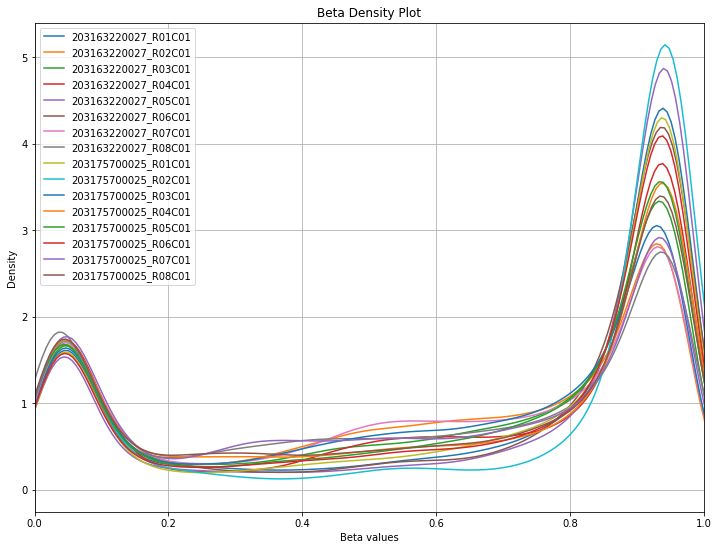

In [9]:
methylcheck.beta_density_plot(df)

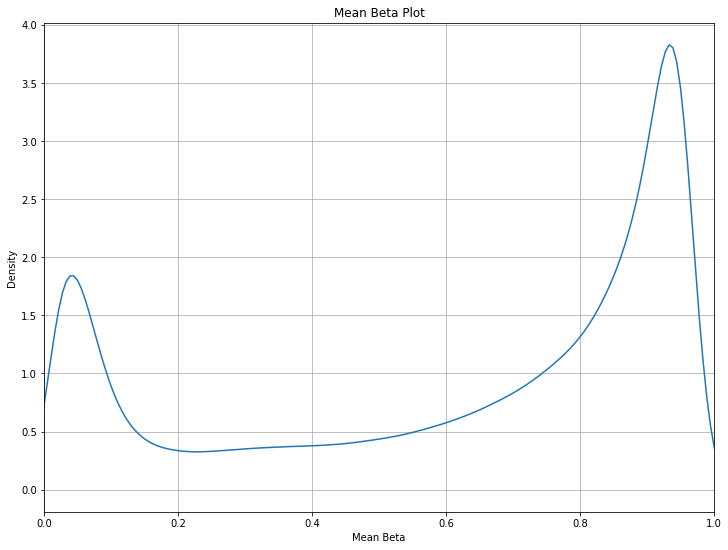

In [10]:
methylcheck.mean_beta_plot(df)

## Filtering probes

Note: Separate from any filtering that ```methylcheck``` does, the qualityMask step of the ```methylprep``` processing pipeline excludes a list of probes that are historically poor quality (```SeSAMe``` masks the same list of probes, which are from the Zhou 2016 paper [linked below]). 

There are several critera for exclusion of probes that ```methylcheck``` offers. These are designed to be in line with past research that has identified "sketchy" probes. Areas that have polymorphisms, cross-hybridization, repeat sequence elements, or base color changes can affect probe quality. ```methylcheck```'s `list_problem_probes()` function returns a list of probes excluded based on literature. For each array type, the publication list is as follows:<br>

- 450k: '[Chen2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3592906/),' '[Price2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3740789/)', '[Zhou2016](https://academic.oup.com/nar/article/45/4/e22/2290930)', '[Naeem2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3943510/)', '[DacaRoszak2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659175/)'
- EPIC: '[Zhou2016](https://academic.oup.com/nar/article/45/4/e22/2290930)', '[McCartney2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4909830/)'

In [12]:
EPIC_criteria = ['McCartney2016', 'Zhou2016', 'Polymorphism', 'CrossHybridization', 'BaseColorChange', 'RepeatSequenceElements']

print('\nEPIC probe exclusion criteria and number of probes excluded:')
for crit in EPIC_criteria:
    print(crit, '--', len(methylcheck.list_problem_probes('EPIC', [crit])))


EPIC probe exclusion criteria and number of probes excluded:
McCartney2016 -- 326267
Zhou2016 -- 178671
Polymorphism -- 346033
CrossHybridization -- 108172
BaseColorChange -- 406
RepeatSequenceElements -- 0


In [11]:
# users can get a list of probes that are filtered by each criteria type
methylcheck.list_problem_probes(array='epic', criteria=['Polymorphism'])[0:5]

['cg23275998', 'cg01637848', 'cg06878499', 'cg01687217', 'cg24094897']

In [13]:
# leave criteria undefined to list all problem probes for that array type
sketchy_probes_list = methylcheck.list_problem_probes(array='epic')

In [14]:
# with the sketchy_probes_list defined above, we use methylcheck.exclude_probes() to remove all the unwanted probes
excluded_df = methylcheck.exclude_probes(df, sketchy_probes_list)
excluded_df.head()

Of {len(df.index)} probes, {post_overlap} matched, yielding {len(df.index)-post_overlap} probes after filtering.


,203163220027_R01C01,203163220027_R02C01,203163220027_R03C01,203163220027_R04C01,203163220027_R05C01,203163220027_R06C01,203163220027_R07C01,203163220027_R08C01,203175700025_R01C01,203175700025_R02C01,203175700025_R03C01,203175700025_R04C01,203175700025_R05C01,203175700025_R06C01,203175700025_R07C01,203175700025_R08C01
IlmnID,,,,,,,,,,,,,,,,
cg00000029,0.852,0.749,0.739,NaN,0.891,0.896,0.757,0.734,0.806,0.881,0.740,0.885,0.693,0.779,0.617,0.891
cg00000109,0.943,0.916,0.884,0.951,0.936,0.774,0.932,0.920,0.898,0.938,0.931,0.953,0.899,0.889,0.734,0.892
cg00000165,0.237,0.733,0.374,0.639,0.397,0.564,0.486,0.194,0.163,0.557,0.531,0.856,0.171,0.173,0.865,0.581
cg00000221,0.943,0.937,0.939,0.926,0.942,0.945,0.938,0.933,0.949,0.936,0.934,0.949,0.944,0.937,0.942,0.934
cg00000236,0.922,0.934,0.919,0.881,0.926,0.882,0.927,0.774,0.937,0.957,0.932,0.952,0.923,0.938,0.932,0.951


To get a sense for how this affects the data, users may want to compare the mean beta density distribution before and after probe filtering.

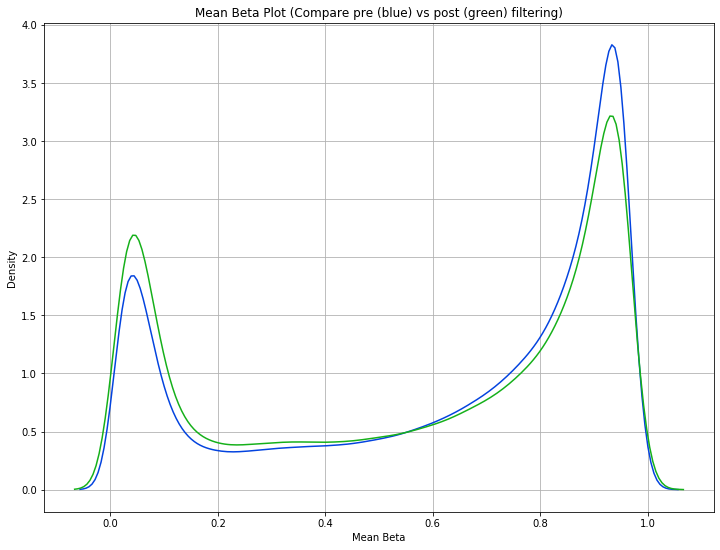

In [15]:
methylcheck.mean_beta_compare(df, excluded_df)

### filtering sex-linked probes

Other probe types that are often filtered out are sex-linked probes and quality control probes used by Illumina. Quality control probes are automatically filtered out in `methylprep` processing with the default `qualityMask`, so there's no need to run `exclude_sex_control_probes` if you processed your data with `methylprep`. Otherwise, we recommend ```methylcheck```'s `exclude_sex_control_probes` to remove both sex-linked probes and quality control probes. 

In [16]:
filtered_df = methylcheck.exclude_sex_control_probes(excluded_df, 'epic', no_sex=True, no_control=True, verbose=True)

epic: Removed 12360 sex-linked probes from 16 samples. 464871 probes remaining.


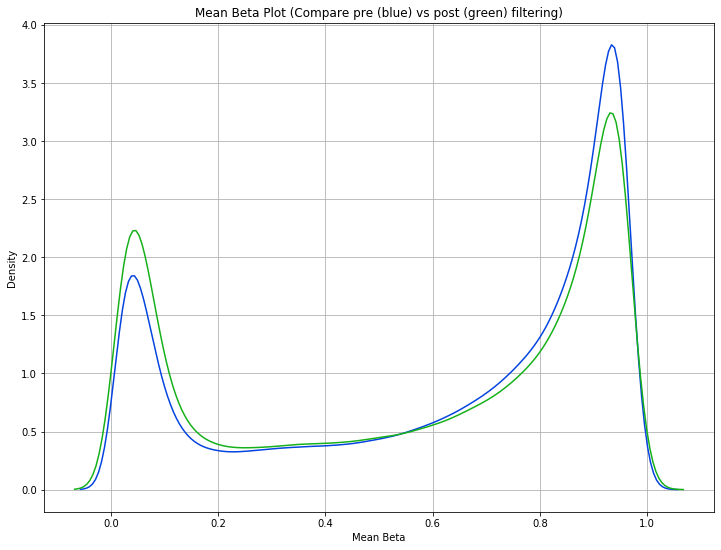

In [17]:
methylcheck.mean_beta_compare(df, filtered_df)

## Quality Control Reporting

`methylcheck` contains a helpful function that mimics Illumina's Bead Array Controls Reporter software ([guide here](https://support.illumina.com/content/dam/illumina-support/documents/documentation/chemistry_documentation/infinium_assays/infinium_hd_methylation/beadarray-controls-reporter-user-guide-1000000004009-00.pdf)). To run this function, the control_probes.pkl file output from ```methylprep``` is required. This report ensures that the chemistry (bisulfite conversion, target specificity, hybridization, staining, etc.) and machine readings are acceptable.

There is an optional portion of this report that relies on values from the poobah file as well. If no poobah file is present, this part is ignored. 

Check the guide linked above for more information on how to read these reports. They're intuitively color-coded (green = passing, red = failing, yellow = somewhere in between) so they're easy to read at a glance. There is a colorblind-friendly option included in this function. 

In [20]:
methylcheck.controls_report(filepath=filepath)

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylationEPIC_manifest_v2.csv


203175700025_R01C01 GA r=0.81 ±0.23 p<0.0 |CT r=0.82 ±0.15 p<0.0
203175700025_R02C01 GA r=0.9 ±0.16 p<0.0 |CT r=0.87 ±0.13 p<0.0
203163220027_R01C01 GA r=0.86 ±0.19 p<0.0 |CT r=0.83 ±0.14 p<0.0
203163220027_R02C01 GA r=0.88 ±0.16 p<0.0 |CT r=0.85 ±0.13 p<0.0
203175700025_R05C01 GA r=0.87 ±0.14 p<0.0 |CT r=0.84 ±0.11 p<0.0
203175700025_R06C01 GA r=0.91 ±0.12 p<0.0 |CT r=0.87 ±0.1 p<0.0
203163220027_R05C01 GA r=0.87 ±0.16 p<0.0 |CT r=0.85 ±0.12 p<0.0
203163220027_R06C01 GA r=0.9 ±0.14 p<0.0 |CT r=0.85 ±0.12 p<0.0
203175700025_R03C01 GA r=0.85 ±0.17 p<0.0 |CT r=0.85 ±0.13 p<0.0
203175700025_R04C01 GA r=0.87 ±0.15 p<0.0 |CT r=0.87 ±0.11 p<0.0
203175700025_R07C01 GA r=0.88 ±0.13 p<0.0 |CT r=0.85 ±0.11 p<0.0


INFO:methylcheck.reports.bead_array:Predicting Sex...
INFO:methylprep.files.manifests:Reading manifest file: HumanMethylationEPIC_manifest_v2.csv


203175700025_R08C01 GA r=0.9 ±0.13 p<0.0 |CT r=0.87 ±0.1 p<0.0
203163220027_R03C01 GA r=0.84 ±0.17 p<0.0 |CT r=0.83 ±0.13 p<0.0
203163220027_R07C01 GA r=0.85 ±0.16 p<0.0 |CT r=0.86 ±0.11 p<0.0
203163220027_R08C01 GA r=0.87 ±0.15 p<0.0 |CT r=0.85 ±0.12 p<0.0
203163220027_R04C01 GA r=0.87 ±0.16 p<0.0 |CT r=0.87 ±0.12 p<0.0
(865859, 16) (865859, 16)


The color-coded results are contained in an excel file that will be saved in the same directory that was specified as an input. It will look similar to this: <br>
![BeadArray Controls Reporter example](https://github.com/FoxoTech/methylcheck/blob/feature/v.0.7.5-docs/docs/bead_array_report.png?raw=true)
<br>
The "Passing Probes" column is the column that relies on values from the poobah file. This is a measure of how many probes failed in each sample (detection p-value > 0.05). The p-value cut off is adjustable with the ```pval_sig``` argument, which is set to 0.05 by default. 

Notice the final column ("Result") where most samples are passing. This column is calculated by checking that all of the QC columns are above a minimum threshold. This threshold is adjustable with the ```passing``` argument (set to 0.7 by default). 



### More details on how "Result" column is calculated

- If the poobah file is included and 20% or more of probes fail, the Result is automatically FAIL.
- If 70% of the columns are passing, the result is "OK" or passing. 
- If more than 70% are passing, but less than 100%, the "OK" will have a number next to it to specify what percentage of columns passed. 
- If less than 70% of the columns passed, the result is either FAIL or MARGINAL (based on how close to the 70% threshold it got). 



The predicted sex column is based on the median values of methylation measurements on the X and Y chromosomes. If ```yMed - xMed``` is less than whatever the specified cutoff value is, it is predicted female. Otherwise, the predicted sex is male. Also, for samples from female subjects, at least 90% of the Y chromosome probes should fail. If there is a sample sheet that includes "sex" or "gender", the reporter will also flag any mismatches between the predicted sex and the specified sex (this does not affect the Result column). 


### Predicting sex

If users want to predict the sex of their samples without generating the entire QC report, they just need the methylated and unmethylated .pkl files generated by `methylprep` and the `get_sex` function.

Darker, smaller markers indicate less variability and a higher confidence in the predicted sex. Our example data is pretty clean and has a good separation between the two sexes. It is occasionally the case that some samples will be misclassified. Those warrant further investigation as they are often poor quality samples that should be excluded or can be the result of a sample swap in the lab. 

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylationEPIC_manifest_v2.csv


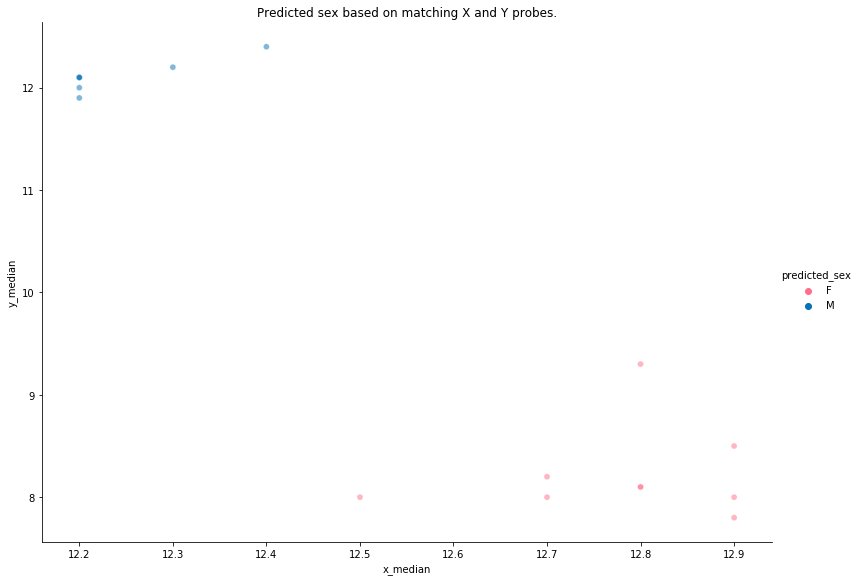

,x_median,y_median,predicted_sex
203163220027_R01C01,12.7,8.0,F
203163220027_R02C01,12.3,12.2,M
203163220027_R03C01,12.8,9.3,F
203163220027_R04C01,12.8,8.1,F
203163220027_R05C01,12.2,12.0,M
203163220027_R06C01,12.2,12.1,M
203163220027_R07C01,12.9,8.5,F
203163220027_R08C01,12.7,8.2,F
203175700025_R01C01,12.5,8.0,F
203175700025_R02C01,12.2,12.1,M


In [21]:
methylcheck.get_sex((meth, unmeth), plot=True)

### Report PDF tool

This is a fully customizable class template for making more advanced quality control reports. It will call a batch of plotting functions and compile a PDF with annotation and save file to disk.

- kwargs: `filename, poobah_max_percent, pval_cutoff, title, author, subject, keywords, outpath, path`

If you want a quick one-line version with no further report editing, try `methylcheck.ReportPDF(runme=True)`.

You can customize your ReportPDF and even pass in customized tables like this:

```python
    # generate report
    report = methylcheck.qc_report.ReportPDF(
        path=working.name,
        poobah_max_percent=10,
        pval_cutoff=0.01,
        title='QC Report',
        author='FOXO Biosciences',
        subject="QC Report",
        keywords="methylation array",
        outpath=working.name,
        filename=report_filename,
        poobah=True,
        on_lambda=True,
        custom_tables=custom_tables,
        debug=True,
        order=['beta_density_plot', 'mds', 'auto_qc',        
            'M_vs_U', 'qc_signal_intensity', 'controls',
            'probe_types'],
    )
    report.run_qc()
    report.pdf.close()
```

### Outlier Detection with Multidimensional Scaling (MDS)

Multidimensional scaling (MDS) is one method for comparing the similarity of samples--similar to PCA. MDS based on euclidean distance will also have identical results to PCA, because minimizing linear distance between points is effectively the same as maximizing linear correlation (the latter being what PCA does). 

```methylcheck``` allows users the option of filtering their data based on the results of MDS. The standard cut off is 1.5 standard deviations from the mean of the data, however users have the ability to adjust the cut off value if they are not satisfied by the filtering. After examining the MDS plot, press 'enter' to accept the cut-off as it is, or enter a new value and rerun the plot. 

We will walk through an example of how to use MDS with this dataset from GEO: [GSE111629](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE111629). This is a large dataset (n=571) of patients with Parkinson's Disease (n=335) and a group of controls (n=237). These blood samples were run on Illumina's 450k arrays. 

We downloaded the data from GEO and processed it with `methylprep` using the following command:

```shell
>>> python -m methylprep process -d <filepath> --all
```

**WARNING:** This is a huge dataset and `methylprep` will take +8 hours to process it. It will also eat up a lot of storage on your machine. We chose this data because it demonstrates the utility of the MDS function. We recommend users pick a different dataset to follow along this example!

In [22]:
filepath = Path('/Users/patriciagirardi/methylcheck_tutorial')
df = pd.read_pickle('~/methylcheck_tutorial/beta_values.pkl')
metadata = pd.read_pickle('~/methylcheck_tutorial/GSE111629_GPL13534_meta_data.pkl')
metadata.head()

,GSM_ID,Sample_Name,source,platform,title,disease state,age,gender,ethnicity,tissue,Sample_ID,Sentrix_ID,Sentrix_Position,description
0,GSM3035401,genomic DNA from 3999979001_R01C01,X3999979001_R01C01,GPL13534,genomic DNA from 3999979001_R01C01,Parkinson's disease (PD),74,Female,Caucasian,whole blood,3999979001_R01C01,3999979001,R01C01,
1,GSM3035402,genomic DNA from 3999979001_R01C02,X3999979001_R01C02,GPL13534,genomic DNA from 3999979001_R01C02,PD-free control,73,Female,Caucasian,whole blood,3999979001_R01C02,3999979001,R01C02,
2,GSM3035403,genomic DNA from 3999979001_R02C01,X3999979001_R02C01,GPL13534,genomic DNA from 3999979001_R02C01,Parkinson's disease (PD),62,Male,Caucasian,whole blood,3999979001_R02C01,3999979001,R02C01,
3,GSM3035404,genomic DNA from 3999979001_R02C02,X3999979001_R02C02,GPL13534,genomic DNA from 3999979001_R02C02,PD-free control,72,Male,Caucasian,whole blood,3999979001_R02C02,3999979001,R02C02,
4,GSM3035405,genomic DNA from 3999979001_R03C01,X3999979001_R03C01,GPL13534,genomic DNA from 3999979001_R03C01,PD-free control,72,Female,Caucasian,whole blood,3999979001_R03C01,3999979001,R03C01,


INFO:methylcheck.samples.postprocessQC:81518.8 probe(s) [avg per sample] were missing values and removed from MDS calculations; 485512 remaining.


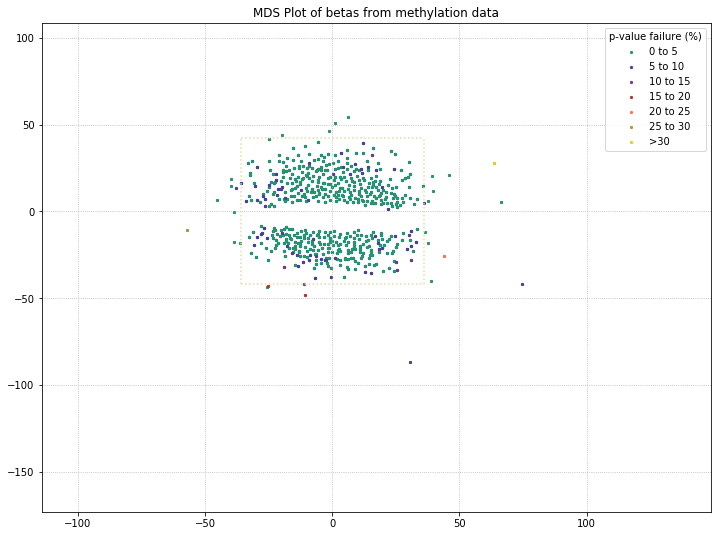

571 original samples; 542 after filtering
Your scale factor was: 2


,3999979001_R01C01,3999979001_R01C02,3999979001_R02C01,3999979001_R02C02,3999979001_R03C01,3999979001_R03C02,3999979001_R04C01,3999979001_R04C02,3999979001_R05C01,3999979001_R05C02,...,9721367028_R01C02,9721367028_R02C02,9721367028_R03C01,9721367028_R03C02,9721367028_R04C01,9721367028_R04C02,9721367028_R05C01,9721367028_R05C02,9721367028_R06C01,9721367028_R06C02
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.586,0.553,0.586,0.551,0.533,0.698,0.713,0.413,0.367,0.655,...,0.706,0.719,0.521,0.643,0.531,0.578,0.518,0.606,NaN,0.532
cg00000108,0.978,0.974,0.972,0.973,0.968,0.973,0.971,0.967,0.970,0.976,...,0.969,0.974,0.970,0.973,0.972,0.968,0.969,0.975,0.966,0.968
cg00000109,0.917,0.925,0.905,0.934,0.922,0.920,0.913,0.918,0.933,0.923,...,0.917,0.929,0.930,0.924,0.930,0.905,0.893,0.912,0.908,0.912
cg00000165,0.221,0.208,NaN,0.185,NaN,NaN,NaN,NaN,0.160,0.209,...,NaN,0.209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000236,0.812,0.881,0.867,0.888,0.843,0.852,0.889,0.815,0.809,0.887,...,0.899,0.888,0.902,0.889,0.875,0.836,0.884,0.868,0.882,0.874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,NaN,0.088,NaN,NaN,0.112,NaN,0.102,NaN,NaN,0.118,...,NaN,0.110,0.103,NaN,NaN,NaN,0.104,0.077,NaN,NaN
ch.X.97133160R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.X.97651759F,0.032,0.030,0.044,0.031,0.029,0.043,0.024,0.038,0.038,0.024,...,0.028,0.025,0.032,0.039,0.041,0.042,0.027,0.027,0.022,0.043


In [23]:
methylcheck.beta_mds_plot(df, filter_stdev=2, poobah=filepath)

There are a few things to note with the MDS plot shown above. We've color-coded the samples in the plot by their poobah value failure rates; the samples with the highest failure rates (yellow, orange) tend to separate from the two clusters. 

The other thing to note is that there are two clusters. With our color-coding scheme, we can only hope that these are the two groups (Parkinson's Disease patients vs. controls). So we need to adjust our color-coding to examine that possibility!

INFO:methylcheck.samples.postprocessQC:81518.8 probe(s) [avg per sample] were missing values and removed from MDS calculations; 485512 remaining.


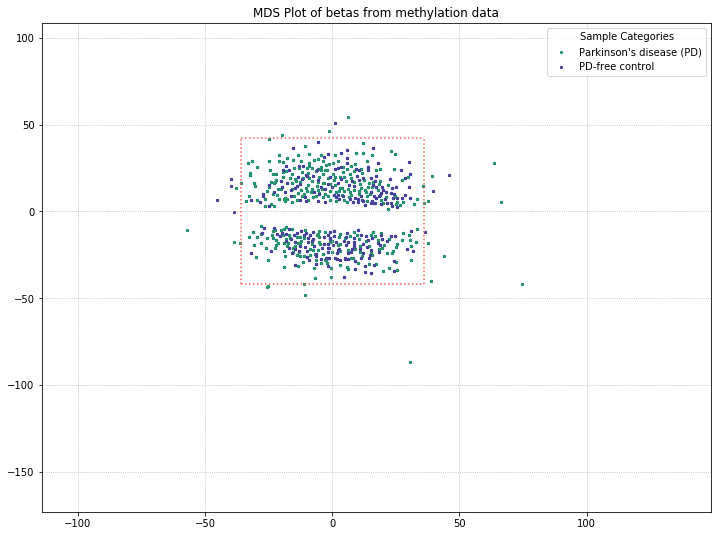

571 original samples; 542 after filtering
Your scale factor was: 2


,3999979001_R01C01,3999979001_R01C02,3999979001_R02C01,3999979001_R02C02,3999979001_R03C01,3999979001_R03C02,3999979001_R04C01,3999979001_R04C02,3999979001_R05C01,3999979001_R05C02,...,9721367028_R01C02,9721367028_R02C02,9721367028_R03C01,9721367028_R03C02,9721367028_R04C01,9721367028_R04C02,9721367028_R05C01,9721367028_R05C02,9721367028_R06C01,9721367028_R06C02
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.586,0.553,0.586,0.551,0.533,0.698,0.713,0.413,0.367,0.655,...,0.706,0.719,0.521,0.643,0.531,0.578,0.518,0.606,NaN,0.532
cg00000108,0.978,0.974,0.972,0.973,0.968,0.973,0.971,0.967,0.970,0.976,...,0.969,0.974,0.970,0.973,0.972,0.968,0.969,0.975,0.966,0.968
cg00000109,0.917,0.925,0.905,0.934,0.922,0.920,0.913,0.918,0.933,0.923,...,0.917,0.929,0.930,0.924,0.930,0.905,0.893,0.912,0.908,0.912
cg00000165,0.221,0.208,NaN,0.185,NaN,NaN,NaN,NaN,0.160,0.209,...,NaN,0.209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000236,0.812,0.881,0.867,0.888,0.843,0.852,0.889,0.815,0.809,0.887,...,0.899,0.888,0.902,0.889,0.875,0.836,0.884,0.868,0.882,0.874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,NaN,0.088,NaN,NaN,0.112,NaN,0.102,NaN,NaN,0.118,...,NaN,0.110,0.103,NaN,NaN,NaN,0.104,0.077,NaN,NaN
ch.X.97133160R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.X.97651759F,0.032,0.030,0.044,0.031,0.029,0.043,0.024,0.038,0.038,0.024,...,0.028,0.025,0.032,0.039,0.041,0.042,0.027,0.027,0.022,0.043


In [24]:
metadata['disease state'].value_counts()

disease_state = metadata[['Sample_ID', 'disease state']]
disease_labels = dict(zip(disease_state['Sample_ID'], disease_state['disease state']))

# There's a small error in the metadata where one of the rows has an empty sample ID column
del disease_labels['']

methylcheck.beta_mds_plot(df, filter_stdev=2, labels=disease_labels)

It appears that disease state isn't responsible for the clustering we're seeing here, based on these results. The PD and control patients are evenly interspersed among the two clusters. There might be some other attribute in the metadata responsible for this, though. The best candidate would be something with a binary result in this dataset, like patient gender. So let's examine what the MDS plot looks like when color-coding by patient gender. 

INFO:methylcheck.samples.postprocessQC:81518.8 probe(s) [avg per sample] were missing values and removed from MDS calculations; 485512 remaining.


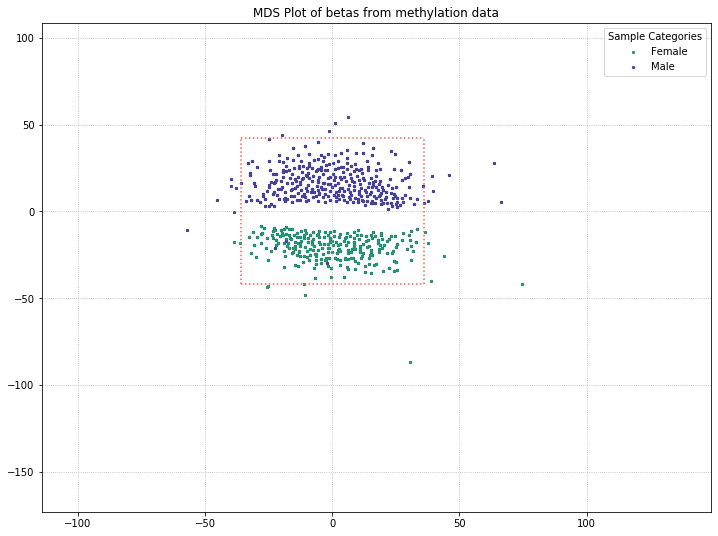

571 original samples; 542 after filtering
Your scale factor was: 2


,3999979001_R01C01,3999979001_R01C02,3999979001_R02C01,3999979001_R02C02,3999979001_R03C01,3999979001_R03C02,3999979001_R04C01,3999979001_R04C02,3999979001_R05C01,3999979001_R05C02,...,9721367028_R01C02,9721367028_R02C02,9721367028_R03C01,9721367028_R03C02,9721367028_R04C01,9721367028_R04C02,9721367028_R05C01,9721367028_R05C02,9721367028_R06C01,9721367028_R06C02
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.586,0.553,0.586,0.551,0.533,0.698,0.713,0.413,0.367,0.655,...,0.706,0.719,0.521,0.643,0.531,0.578,0.518,0.606,NaN,0.532
cg00000108,0.978,0.974,0.972,0.973,0.968,0.973,0.971,0.967,0.970,0.976,...,0.969,0.974,0.970,0.973,0.972,0.968,0.969,0.975,0.966,0.968
cg00000109,0.917,0.925,0.905,0.934,0.922,0.920,0.913,0.918,0.933,0.923,...,0.917,0.929,0.930,0.924,0.930,0.905,0.893,0.912,0.908,0.912
cg00000165,0.221,0.208,NaN,0.185,NaN,NaN,NaN,NaN,0.160,0.209,...,NaN,0.209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000236,0.812,0.881,0.867,0.888,0.843,0.852,0.889,0.815,0.809,0.887,...,0.899,0.888,0.902,0.889,0.875,0.836,0.884,0.868,0.882,0.874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,NaN,0.088,NaN,NaN,0.112,NaN,0.102,NaN,NaN,0.118,...,NaN,0.110,0.103,NaN,NaN,NaN,0.104,0.077,NaN,NaN
ch.X.97133160R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.X.97651759F,0.032,0.030,0.044,0.031,0.029,0.043,0.024,0.038,0.038,0.024,...,0.028,0.025,0.032,0.039,0.041,0.042,0.027,0.027,0.022,0.043


In [25]:
gender = metadata[['Sample_ID', 'gender']]
gender_labels = dict(zip(gender['Sample_ID'], gender['gender']))
del gender_labels['']

methylcheck.beta_mds_plot(df, filter_stdev=2, labels=gender_labels)

It looks like this might be the culprit of the two clusters in the MDS plot! There are a few outliers, but for the most part, the two clusters are made up of one gender each.

We can pull out the beta values from X/Y probes and just examine beta values from probes on the autosomal chromosomes. If MDS is picking up on differences between patient sex and clustering the patients accordingly, we might be able to get at an underlying difference by removing sex from the equation.  

INFO:methylcheck.samples.postprocessQC:79013.0 probe(s) [avg per sample] were missing values and removed from MDS calculations; 473864 remaining.


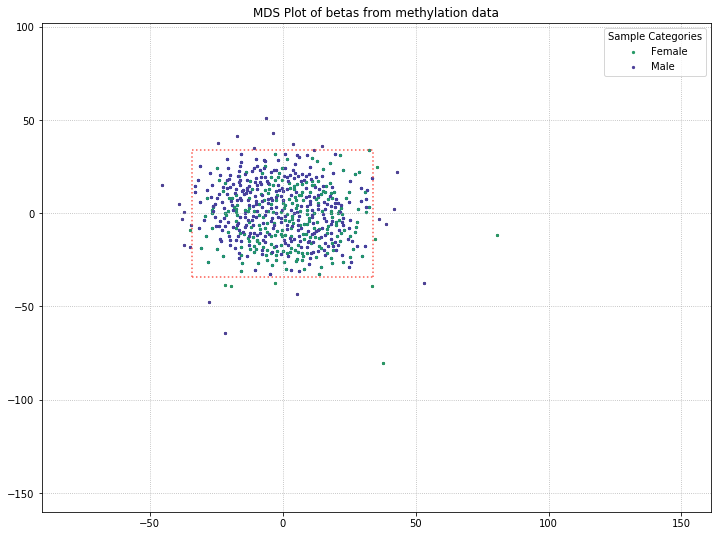

571 original samples; 539 after filtering
Your scale factor was: 2


,3999979001_R01C01,3999979001_R01C02,3999979001_R02C01,3999979001_R02C02,3999979001_R03C01,3999979001_R03C02,3999979001_R04C01,3999979001_R05C01,3999979001_R05C02,3999979001_R06C01,...,9721367028_R01C02,9721367028_R02C02,9721367028_R03C01,9721367028_R03C02,9721367028_R04C01,9721367028_R04C02,9721367028_R05C01,9721367028_R05C02,9721367028_R06C01,9721367028_R06C02
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.586,0.553,0.586,0.551,0.533,0.698,0.713,0.367,0.655,0.695,...,0.706,0.719,0.521,0.643,0.531,0.578,0.518,0.606,NaN,0.532
cg00000108,0.978,0.974,0.972,0.973,0.968,0.973,0.971,0.970,0.976,0.976,...,0.969,0.974,0.970,0.973,0.972,0.968,0.969,0.975,0.966,0.968
cg00000109,0.917,0.925,0.905,0.934,0.922,0.920,0.913,0.933,0.923,0.925,...,0.917,0.929,0.930,0.924,0.930,0.905,0.893,0.912,0.908,0.912
cg00000165,0.221,0.208,NaN,0.185,NaN,NaN,NaN,0.160,0.209,0.265,...,NaN,0.209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000236,0.812,0.881,0.867,0.888,0.843,0.852,0.889,0.809,0.887,0.880,...,0.899,0.888,0.902,0.889,0.875,0.836,0.884,0.868,0.882,0.874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.9.98937537R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.9.98957343R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.9.98959675F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
no_sex_probes = methylcheck.exclude_sex_control_probes(df, array='450k', no_sex=True, no_control=True)

methylcheck.beta_mds_plot(no_sex_probes, filter_stdev=2, labels=gender_labels)

We lost the separation between clusters as a result of pulling out sex probes.

Now let's try to plot this filtered data with the disease state labelling, in case there is some subtle grouping going on. 

INFO:methylcheck.samples.postprocessQC:79013.0 probe(s) [avg per sample] were missing values and removed from MDS calculations; 473864 remaining.


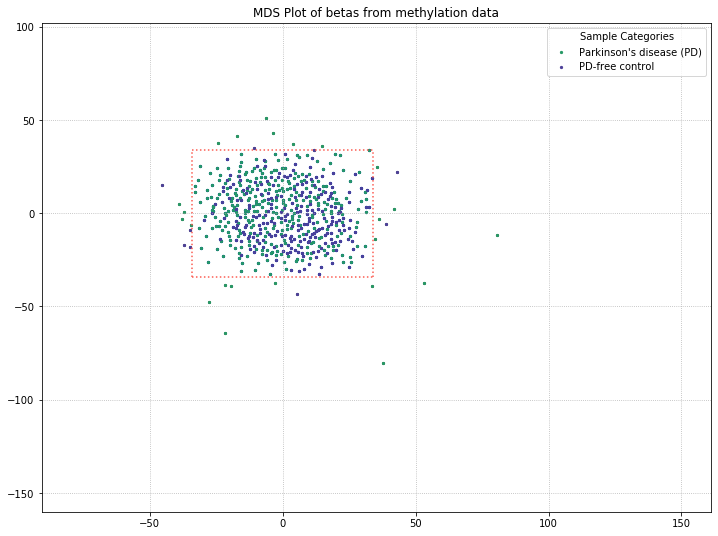

571 original samples; 539 after filtering
Your scale factor was: 2


,3999979001_R01C01,3999979001_R01C02,3999979001_R02C01,3999979001_R02C02,3999979001_R03C01,3999979001_R03C02,3999979001_R04C01,3999979001_R05C01,3999979001_R05C02,3999979001_R06C01,...,9721367028_R01C02,9721367028_R02C02,9721367028_R03C01,9721367028_R03C02,9721367028_R04C01,9721367028_R04C02,9721367028_R05C01,9721367028_R05C02,9721367028_R06C01,9721367028_R06C02
IlmnID,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.586,0.553,0.586,0.551,0.533,0.698,0.713,0.367,0.655,0.695,...,0.706,0.719,0.521,0.643,0.531,0.578,0.518,0.606,NaN,0.532
cg00000108,0.978,0.974,0.972,0.973,0.968,0.973,0.971,0.970,0.976,0.976,...,0.969,0.974,0.970,0.973,0.972,0.968,0.969,0.975,0.966,0.968
cg00000109,0.917,0.925,0.905,0.934,0.922,0.920,0.913,0.933,0.923,0.925,...,0.917,0.929,0.930,0.924,0.930,0.905,0.893,0.912,0.908,0.912
cg00000165,0.221,0.208,NaN,0.185,NaN,NaN,NaN,0.160,0.209,0.265,...,NaN,0.209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000236,0.812,0.881,0.867,0.888,0.843,0.852,0.889,0.809,0.887,0.880,...,0.899,0.888,0.902,0.889,0.875,0.836,0.884,0.868,0.882,0.874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.9.98937537R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.9.98957343R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ch.9.98959675F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
methylcheck.beta_mds_plot(no_sex_probes, filter_stdev=2, labels=disease_labels)

It appears that the differences between these two disease states aren't being picked up by MDS in a meaningful way. We'll do one more MDS plot on these filtered probes to check how many of those outlier samples have high detection p-value failure rates.

Also, we can define a variable here to access the samples that pass after they've been filtered by MDS. Then, we can compare that beta distribution to the original beta distribution to see how the MDS filtering affected it. 

INFO:methylcheck.samples.postprocessQC:79013.0 probe(s) [avg per sample] were missing values and removed from MDS calculations; 473864 remaining.


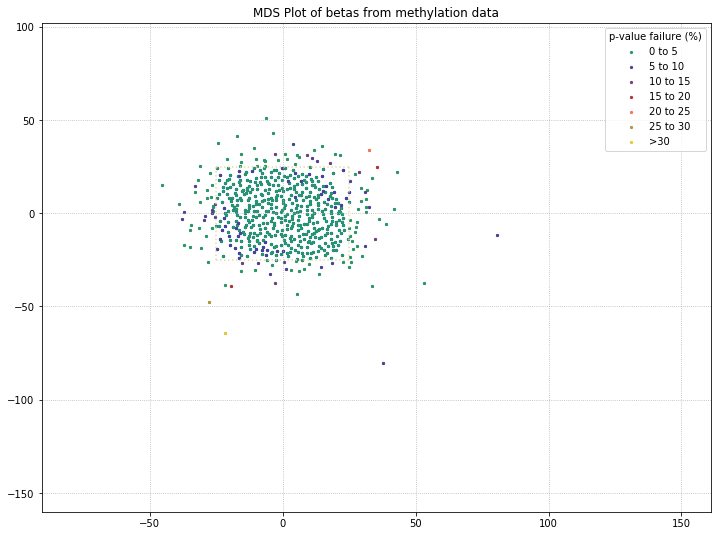

571 original samples; 448 after filtering
Your scale factor was: 1.5


In [28]:
mds_filtered = methylcheck.beta_mds_plot(no_sex_probes, filter_stdev=1.5, poobah=filepath)

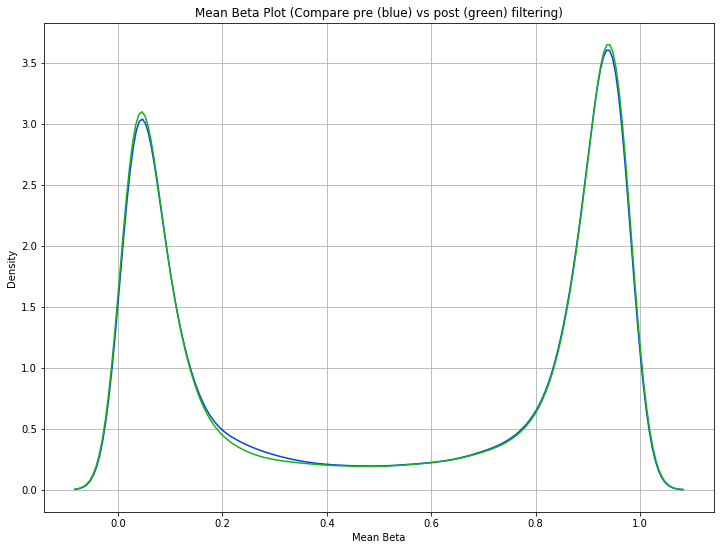

In [29]:
methylcheck.mean_beta_compare(df, mds_filtered)

The difference is a bit subtle since even the low quality data in this dataset is relatively high quality, but you can see that the green curve (MDS filtered samples) has higher and tighter peaks than the blue curve (unfiltered data). This means we were able to eliminate some of the samples that had a lot of beta values falling in that midrange between the peaks. 